In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
rm_path = "ckpts/rm2_atmoic_facts_llama7B/checkpoint_10000/hf_model/"
rm_gpt3pt5_path = "ckpts/rm2_atmoic_facts_gpt3pt5_llama7B/checkpoint_10000/hf_model/"
rm_50_50_path = "ckpts/rm_atmoic_facts_llama7B_50_50/checkpoint_10000/hf_model/"


In [4]:
rm_false_preds = np.load(rm_path + "test_medium_False_facts_preds.npy")
rm_true_preds = np.load(rm_path + "test_medium_True_facts_preds.npy")

rm_gpt3pt5_false_preds = np.load(rm_gpt3pt5_path + "test_medium_False_facts_preds.npy")
rm_gpt3pt5_true_preds = np.load(rm_gpt3pt5_path + "test_medium_True_facts_preds.npy")

rm_50_50_false_preds = np.load(rm_50_50_path + "test_medium_False_facts_preds.npy")
rm_50_50_true_preds = np.load(rm_50_50_path + "test_medium_True_facts_preds.npy")


In [5]:
atomic_facts_model_path = "ckpts/sft_atomic_facts_llama7B/checkpoint_01000/hf_model/"
true_facts = np.load(atomic_facts_model_path+"test_medium_True_facts.npy", allow_pickle=True).item()
false_facts = np.load(atomic_facts_model_path+"test_medium_False_facts.npy", allow_pickle=True).item()

In [6]:
num_entities  = np.load("num_pretrain_entities/bios_test_points_pkl_medium.npy")
num_entities_bins = np.percentile(num_entities, [0, 75, 80, 85, 90, 95, 100])

num_entities_bins = [0, 200, 400, 600, 800, 1000, np.inf]


In [7]:
np.percentile(num_entities, [0, 75, 80, 85, 90, 95, 100])

array([-1.00000e+00,  4.00000e+00,  1.06000e+02,  2.11000e+02,
        4.70800e+02,  1.10280e+03,  2.03199e+05])

(array([233., 255., 129.,  94.,  70.,  70.,  46.,  37.,  30.,  21.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <BarContainer object of 10 artists>)

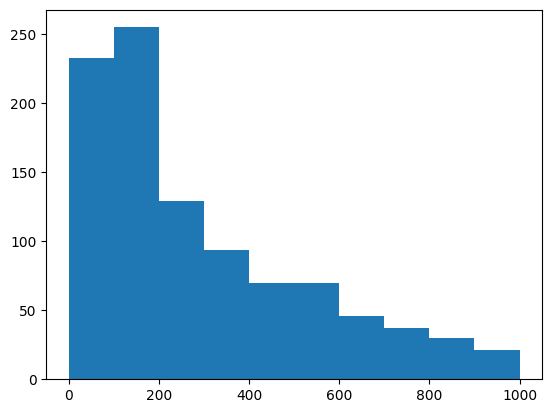

In [8]:
plt.hist(num_entities, range=(0, 1000))

In [9]:

def get_bin_average(x_axis, y_axis, bins):
    x_axis = np.array(x_axis)
    y_axis = np.array(y_axis)
    bin_avgs = []
    for i in range(len(bins)-1):
        idxs = np.where((x_axis >= bins[i]) & (x_axis < bins[i+1]))[0]
        bin_avgs.append(np.mean(y_axis[idxs]))
    return np.array(bin_avgs)


def get_bin_std(x_axis, y_axis, bins):
    x_axis = np.array(x_axis)
    y_axis = np.array(y_axis)
    bin_stds = []
    for i in range(len(bins)-1):
        idxs = np.where((x_axis >= bins[i]) & (x_axis < bins[i+1]))[0]
        bin_stds.append(np.std(y_axis[idxs]))
    return np.array(bin_stds)


In [10]:
rm_num_correct_pred_per_bio = []
rm_num_incorrect_pred_per_bio = []

rm_gpt3pt5_num_correct_pred_per_bio = []
rm_gpt3pt5_num_incorrect_pred_per_bio = []

rm_50_50_num_correct_pred_per_bio = []
rm_50_50_num_incorrect_pred_per_bio = []

num_facts_per_bio = []
for i in range(max(true_facts["bio_idxs"])+1):
    idxs = np.where(np.array(true_facts["bio_idxs"]) == i)[0]
    rm_num_correct_pred_per_bio.append((rm_true_preds[idxs]== " Yes.").sum())
    rm_num_incorrect_pred_per_bio.append((rm_true_preds[idxs]== " No.").sum())

    rm_gpt3pt5_num_correct_pred_per_bio.append((rm_gpt3pt5_true_preds[idxs]== " Yes.").sum())
    rm_gpt3pt5_num_incorrect_pred_per_bio.append((rm_gpt3pt5_true_preds[idxs]== " No.").sum())

    rm_50_50_num_correct_pred_per_bio.append((rm_50_50_true_preds[idxs]== " Yes.").sum())
    rm_50_50_num_incorrect_pred_per_bio.append((rm_50_50_true_preds[idxs]== " No.").sum())

    num_facts_per_bio.append(len(idxs))



In [11]:
rm_reward_pred_per_bio = 2*np.array(rm_num_correct_pred_per_bio) - 3*np.array(rm_num_incorrect_pred_per_bio)
rm_gpt3pt5_reward_pred_per_bio = 2*np.array(rm_gpt3pt5_num_correct_pred_per_bio) - 3*np.array(rm_gpt3pt5_num_incorrect_pred_per_bio)
rm_50_50_reward_pred_per_bio = 2*np.array(rm_50_50_num_correct_pred_per_bio) - 3*np.array(rm_50_50_num_incorrect_pred_per_bio)

ground_truth_reward_per_bio = 2*np.array(num_facts_per_bio)

In [12]:
get_bin_std(num_entities, ground_truth_reward_per_bio, num_entities_bins)

array([4.40595691, 4.10462616, 3.35261092, 4.51059622, 3.17515354,
       3.60923626])

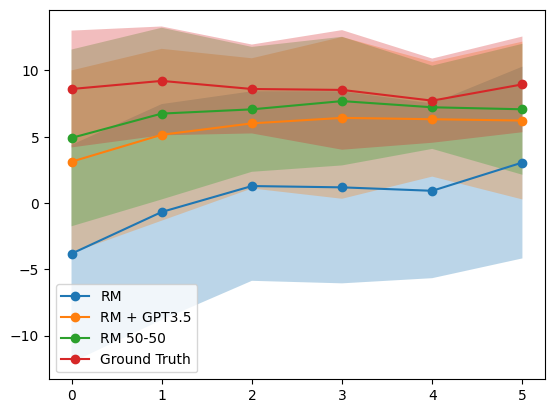

In [13]:
mean = get_bin_average(num_entities, rm_reward_pred_per_bio, num_entities_bins)
std = get_bin_std(num_entities, rm_reward_pred_per_bio, num_entities_bins)

plt.plot(np.arange(0, len(num_entities_bins)-1), mean,"o-", label="RM")
plt.fill_between(np.arange(0, len(num_entities_bins)-1), mean-std, mean+std, alpha=0.3)

mean = get_bin_average(num_entities, rm_gpt3pt5_reward_pred_per_bio, num_entities_bins)
std = get_bin_std(num_entities, rm_gpt3pt5_reward_pred_per_bio, num_entities_bins)
plt.plot(np.arange(0, len(num_entities_bins)-1), mean,"o-", label="RM + GPT3.5")
plt.fill_between(np.arange(0, len(num_entities_bins)-1), mean-std, mean+std, alpha=0.3)

mean = get_bin_average(num_entities, rm_50_50_reward_pred_per_bio, num_entities_bins)
std = get_bin_std(num_entities, rm_50_50_reward_pred_per_bio, num_entities_bins)
plt.plot(np.arange(0, len(num_entities_bins)-1), mean,"o-", label="RM 50-50")
plt.fill_between(np.arange(0, len(num_entities_bins)-1), mean-std, mean+std, alpha=0.3)

mean = get_bin_average(num_entities, ground_truth_reward_per_bio, num_entities_bins)
std = get_bin_std(num_entities, ground_truth_reward_per_bio, num_entities_bins)
plt.plot(np.arange(0, len(num_entities_bins)-1), mean,"o-", label="Ground Truth")
plt.fill_between(np.arange(0, len(num_entities_bins)-1), mean-std, mean+std, alpha=0.3)

plt.legend()

In [201]:
rm_num_correct_pred_per_bio = []
rm_num_incorrect_pred_per_bio = []

rm_gpt3pt5_num_correct_pred_per_bio = []
rm_gpt3pt5_num_incorrect_pred_per_bio = []

rm_50_50_num_correct_pred_per_bio = []
rm_50_50_num_incorrect_pred_per_bio = []

num_facts_per_bio = []
for i in range(max(false_facts["bio_idxs"])+1):
    idxs = np.where(np.array(false_facts["bio_idxs"]) == i)[0]
    rm_num_correct_pred_per_bio.append((rm_false_preds[idxs]== " Yes.").sum())
    rm_num_incorrect_pred_per_bio.append((rm_false_preds[idxs]== " No.").sum())

    rm_gpt3pt5_num_correct_pred_per_bio.append((rm_gpt3pt5_false_preds[idxs]== " Yes.").sum())
    rm_gpt3pt5_num_incorrect_pred_per_bio.append((rm_gpt3pt5_false_preds[idxs]== " No.").sum())

    rm_50_50_num_correct_pred_per_bio.append((rm_50_50_false_preds[idxs]== " Yes.").sum())
    rm_50_50_num_incorrect_pred_per_bio.append((rm_50_50_false_preds[idxs]== " No.").sum())

    num_facts_per_bio.append(len(idxs))


In [202]:
rm_reward_pred_per_bio = 2*np.array(rm_num_correct_pred_per_bio) - 3*np.array(rm_num_incorrect_pred_per_bio)
rm_gpt3pt5_reward_pred_per_bio = 2*np.array(rm_gpt3pt5_num_correct_pred_per_bio) - 3*np.array(rm_gpt3pt5_num_incorrect_pred_per_bio)
rm_50_50_reward_pred_per_bio = 2*np.array(rm_50_50_num_correct_pred_per_bio) - 3*np.array(rm_50_50_num_incorrect_pred_per_bio)

ground_truth_reward_per_bio = -3*np.array(num_facts_per_bio)

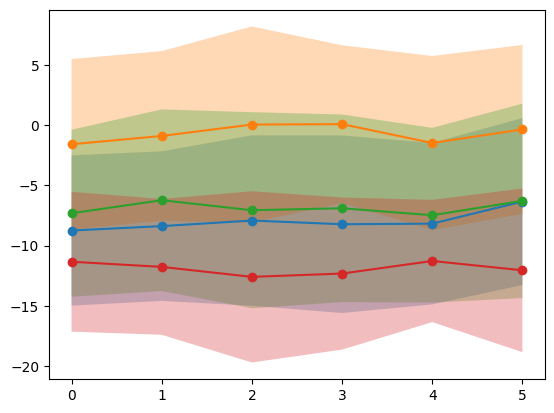

In [203]:
mean = get_bin_average(num_entities, rm_reward_pred_per_bio, num_entities_bins)
std = get_bin_std(num_entities, rm_reward_pred_per_bio, num_entities_bins)

plt.plot(np.arange(0, len(num_entities_bins)-1), mean,"o-", label="RM")
plt.fill_between(np.arange(0, len(num_entities_bins)-1), mean-std, mean+std, alpha=0.3)

mean = get_bin_average(num_entities, rm_gpt3pt5_reward_pred_per_bio, num_entities_bins)
std = get_bin_std(num_entities, rm_gpt3pt5_reward_pred_per_bio, num_entities_bins)
plt.plot(np.arange(0, len(num_entities_bins)-1), mean,"o-", label="RM + GPT3.5")
plt.fill_between(np.arange(0, len(num_entities_bins)-1), mean-std, mean+std, alpha=0.3)

mean = get_bin_average(num_entities, rm_50_50_reward_pred_per_bio, num_entities_bins)
std = get_bin_std(num_entities, rm_50_50_reward_pred_per_bio, num_entities_bins)
plt.plot(np.arange(0, len(num_entities_bins)-1), mean,"o-", label="RM 50-50")
plt.fill_between(np.arange(0, len(num_entities_bins)-1), mean-std, mean+std, alpha=0.3)

mean = get_bin_average(num_entities, ground_truth_reward_per_bio, num_entities_bins)
std = get_bin_std(num_entities, ground_truth_reward_per_bio, num_entities_bins)
plt.plot(np.arange(0, len(num_entities_bins)-1), mean,"o-", label="Ground Truth")
plt.fill_between(np.arange(0, len(num_entities_bins)-1), mean-std, mean+std, alpha=0.3)

In [204]:
test_medium_False_facts = np.load("ckpts/sft_atomic_facts_llama7B/checkpoint_01000/hf_model/test_medium_False_facts.npy", allow_pickle=True).item()

idxs = np.where(np.array(false_facts["bio_idxs"]) == 5)[0]

np.array(false_facts["facts"])[idxs]



array(['Helie Lee is an American.', 'Helie Lee is a video-game designer.',
       'Helie Lee is an artist.', 'Helie Lee is an animator.'],
      dtype='<U415')

In [157]:
import pickle

with open("biographies/test_bios_medium.pkl", "rb") as f:
    test_bios_medium = pickle.load(f)
names = test_bios_medium["name"]

In [165]:
names[5]

'Helie Lee'